In [1]:
import os
import re
import math
import typing
import warnings
from enum import Enum

import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib as mpl
from scipy.stats import zscore
import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split

from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important}; </style>"))

In [2]:
warnings.filterwarnings(
    action='ignore',
    message='înternal gelsd'
)

warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning
)

np.random.seed(1)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# Matplotlib set label size
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

In [4]:
sns.set_style('whitegrid')
sns.set_context(
    'notebook',
    font_scale=1,
    rc={
        'lines.linewidth': 2,
        'font.family': [u'times']
    }
)

## Loading Data

In [62]:
train_set = pd.read_csv('./data/train_set.csv', index_col=0)
test_set = pd.read_csv('./data/test_set.csv', index_col=0)

<AxesSubplot:>

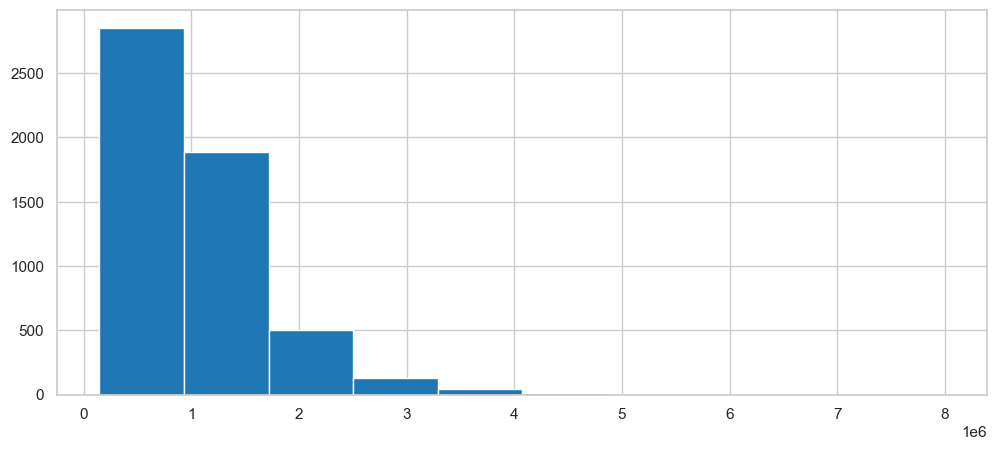

In [6]:
train_set.Price.hist()

<AxesSubplot:>

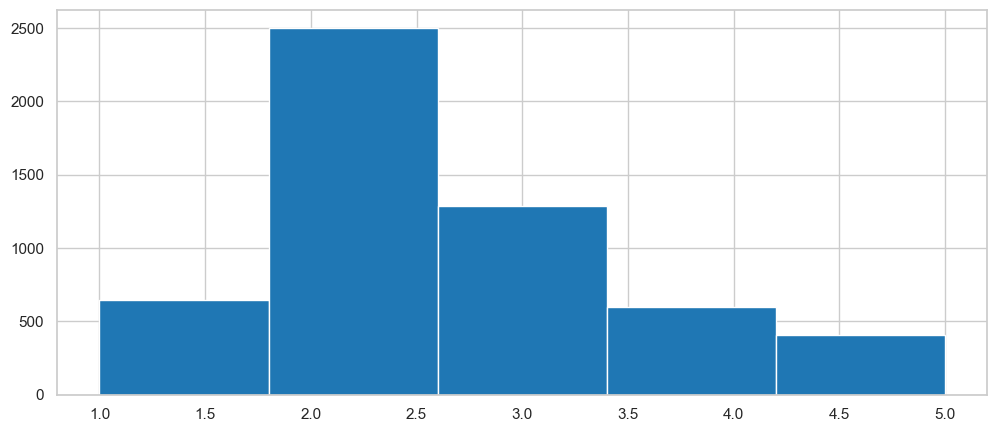

In [65]:
train_set['price_range'] = pd.cut(train_set.Price, bins=[.0, .5e6, 1e6, 1.5e6, 2e6, 10e6], labels=[1, 2, 3, 4, 5])
train_set['price_range'].hist(bins=5)

In [66]:
def train_val_split(train_set: pd.DataFrame, stratify_col: str = 'price_range'):
    train_set_target = train_set[stratify_col]

    X_train, X_valid, Y_train, Y_valid = train_test_split(
        train_set, 
        train_set_target, 
        stratify=train_set_target, 
        test_size=.15,
        random_state=0
    )
    
    return pd.concat([X_train, Y_train], axis=1), pd.concat([X_valid, Y_valid], axis=1)

In [67]:
train_set, valid_set = train_val_split(train_set)

## EDA

In [27]:
train_set.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,4617.000000,4.617000e+03,4617.000000,4617.000000,4617.000000,4617.000000,4595.000000,4617.000000,2435.000000,2801.000000,4617.000000,4617.000000,4617.000000
mean,2.938705,1.078467e+06,10.261057,3105.903617,2.918562,1.537362,1.631338,538.927442,167.292700,1965.311674,-37.810119,144.994463,7379.346979
std,0.951790,6.454600e+05,6.038494,94.448991,0.993194,0.699995,0.990320,1614.688646,917.783312,36.274513,0.079175,0.108455,4341.521714
min,1.000000,1.450000e+05,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1830.000000,-38.174880,144.542370,389.000000
25%,2.000000,6.500000e+05,6.200000,3044.000000,2.000000,1.000000,1.000000,185.000000,92.000000,1940.000000,-37.857100,144.927500,4217.000000
50%,3.000000,9.000000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,451.000000,125.000000,1970.000000,-37.803500,144.999400,6543.000000
75%,3.000000,1.331000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,656.000000,175.000000,2000.000000,-37.757690,145.058790,10331.000000
max,8.000000,8.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,75100.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


<AxesSubplot:xlabel='Type', ylabel='count'>

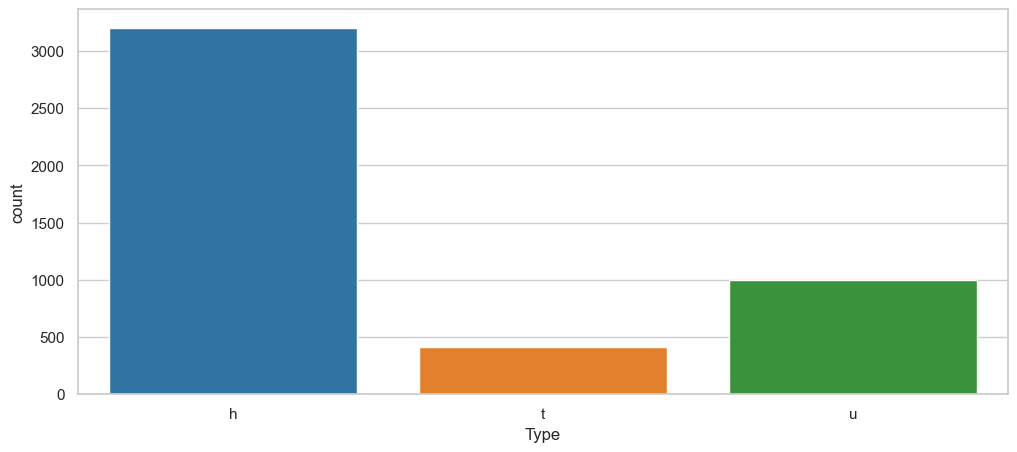

In [24]:
sns.countplot(x='Type', data=train_set)

<AxesSubplot:xlabel='Longtitude', ylabel='Lattitude'>

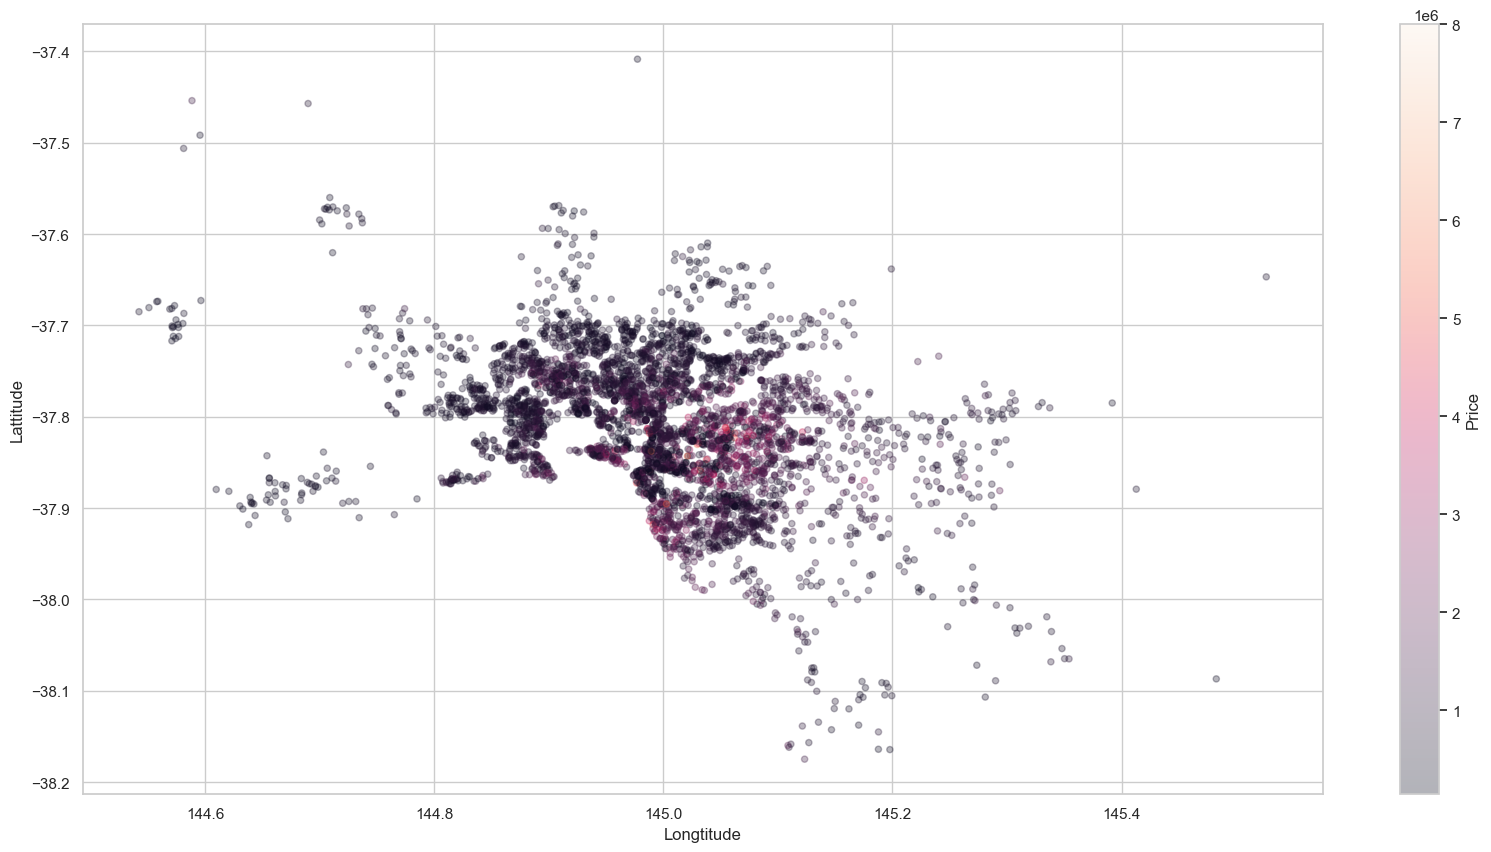

In [26]:
train_set.plot(
    kind='scatter',
    x='Longtitude',
    y='Lattitude',
    alpha=.3,
    figsize=(20, 10),
    c='Price', 
    cmap=plt.get_cmap('jet'),
    colorbar=True,
    sharex=False
)

<AxesSubplot:>

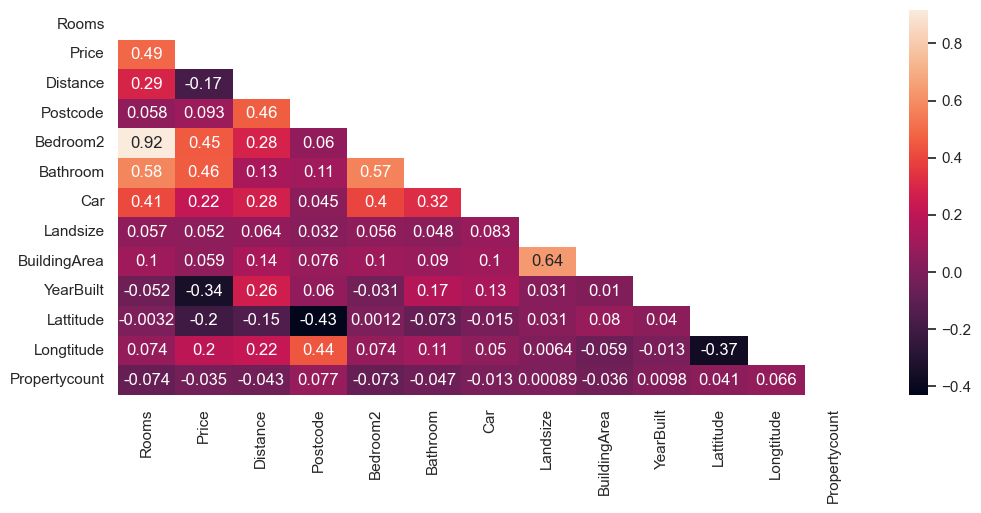

In [28]:
corr = train_set.corr(numeric_only=True)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(
    corr,
    annot=True,
    mask=matrix
)

In [33]:
corr_sorted = corr['Price'].sort_values()
corr_sorted

YearBuilt       -0.344287
Lattitude       -0.204988
Distance        -0.174566
Propertycount   -0.035337
Landsize         0.051705
BuildingArea     0.059124
Postcode         0.092615
Longtitude       0.200117
Car              0.219901
Bedroom2         0.450831
Bathroom         0.457246
Rooms            0.488317
Price            1.000000
Name: Price, dtype: float64

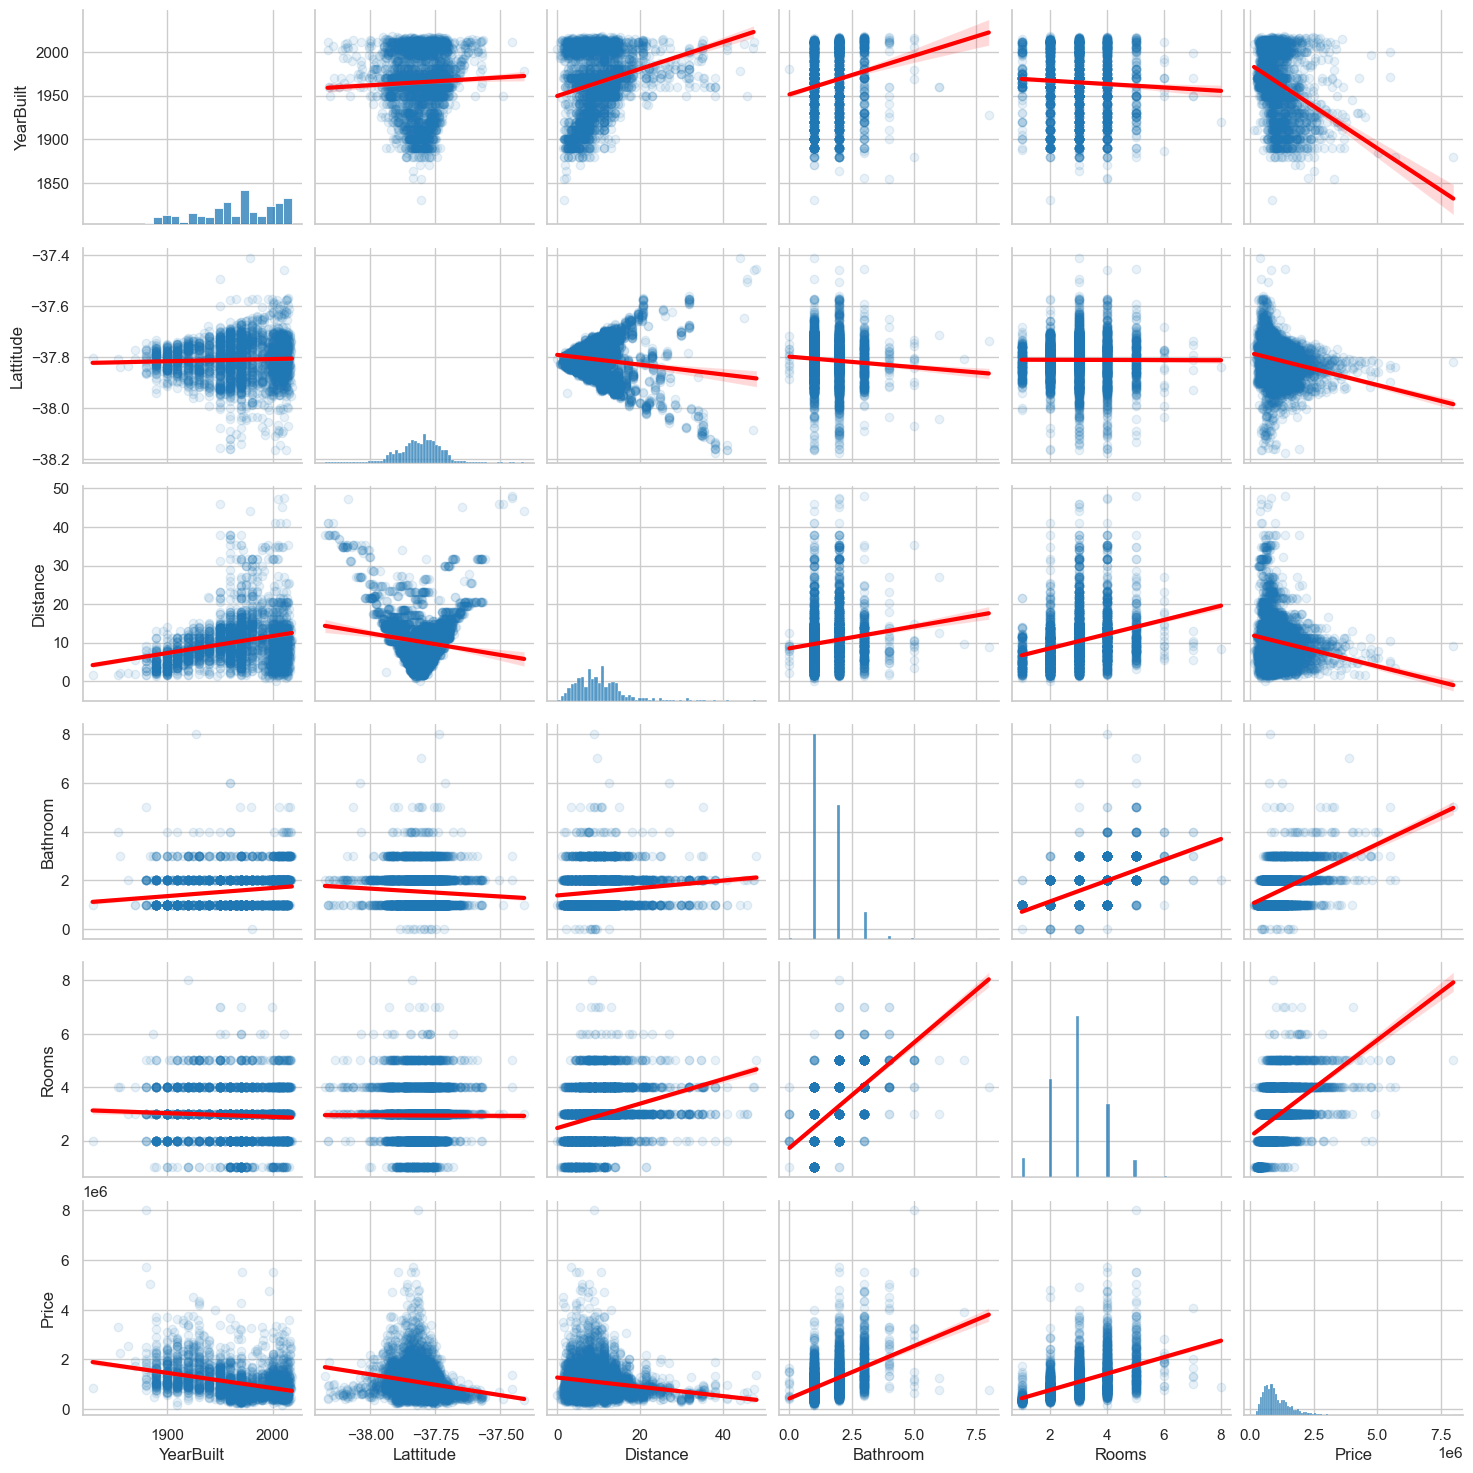

In [44]:
# Will do pair plot with most correlated values
sns.pairplot(
    train_set[corr_sorted.index[:3].tolist() + corr_sorted.index[-3:].tolist()],
    kind='reg',
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}}
)

## Data Processing

In [46]:
print(train_set.isnull().sum(axis=0).to_string())

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                22
Landsize            0
BuildingArea     2182
YearBuilt        1816
CouncilArea       477
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
price_range         0
price_range         0


In [68]:
train_set_processed = train_set.copy()
valid_set_processed = valid_set.copy()
test_set_processed = test_set.copy()

### Handling NaNs

#### Car

<AxesSubplot:xlabel='Price', ylabel='Count'>

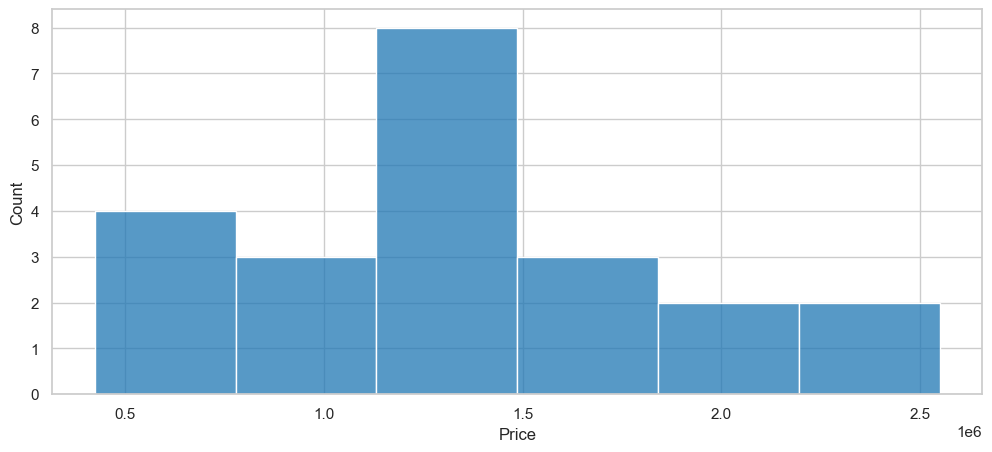

In [69]:
# How is the distribution of price when car is not set
sns.histplot(
    train_set_processed[train_set_processed.Car.isnull()]['Price']
)

In [51]:
def handle_null_car(train_df, valid_df, test_df, year_not_car: int = 1940):
    """
    We will assume that for the nulls in the year before year_not_car, are because there as effectively no car.
    
    """
    train_df.loc[
        (train_df['YearBuilt'] < year_not_car).index,
        'Car'
    ] = 0

    valid_df.loc[
        (valid_df['YearBuilt'] < year_not_car).index,
        'Car'
    ] = 0

    test_df.loc[
        (test_df['YearBuilt'] < year_not_car).index,
        'Car'
    ] = 0
    
    # For the other ones would place the median
    train_set_median = train_df['Car'].median()

    train_df['Car'].fillna(train_set_median, inplace=True)
    valid_df['Car'].fillna(train_set_median, inplace=True)
    test_df['Car'].fillna(train_set_median, inplace=True)
    
    return train_df, valid_df, test_df

In [70]:
train_set_processed, valid_set_processed, test_set_processed = handle_null_car(train_set_processed, valid_set_processed, test_set_processed)

#### CouncilArea

Will can try to use a **k-nearest neighbor**, as the council area depends a lot in the position of longtitude and lattitude.

In [82]:
train_set_processed.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,price_range,price_range
index,,,,,,,,,,,,,,,,,,,,,
1845,Kensington,51 Rankins Rd,2,h,765000.0,S,Nardella,10/12/2016,4.2,3031.0,...,158.0,76.0,1965.0,Melbourne,-37.79020,144.93190,Northern Metropolitan,5263.0,2,2
828,Blackburn,18 Masons Rd,2,h,1500000.0,S,Noel,15/07/2017,13.4,3130.0,...,1021.0,NaN,NaN,Whitehorse,-37.83189,145.15785,Eastern Metropolitan,5713.0,3,3
973,Preston,1/61 Eton St,3,h,485000.0,PI,Barry,12/11/2016,8.8,3072.0,...,244.0,NaN,NaN,Darebin,-37.74440,145.02020,Northern Metropolitan,14577.0,1,1


In [73]:
test_set_processed.isnull().sum(axis=0)

Suburb              0
Address             0
Rooms               0
Type                0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                 0
Landsize            0
BuildingArea     3908
YearBuilt        3245
CouncilArea       816
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [75]:
train_set_base = train_set_processed.dropna(subset=['CouncilArea'])
train_set_target = train_set_processed[train_set_processed['CouncilArea'].isna()]

# Explicative variables
X_train_base_set_council = train_set_base[['Lattitude', 'Longtitude']]
X_train_target_set_council = train_set_target[['Lattitude', 'Longtitude']]
X_train_target_set_council_index = X_train_target_set_council.index

# Target variables
Y_train_base_set_council = train_set_base['CouncilArea'].values.ravel()

In [76]:
# Scale the inputs
scaler = StandardScaler()

X_train_base_set_council = scaler.fit_transform(X_train_base_set_council)
X_train_target_set_council = scaler.transform(X_train_target_set_council)

In [95]:
# Train the model
n_council_area = train_set_processed['CouncilArea'].nunique()
knn_council_area = KNeighborsClassifier(n_council_area)

knn_council_area.fit(X_train_base_set_council, Y_train_base_set_council)

KNeighborsClassifier(n_neighbors=32)

In [94]:
accuracy_score(knn_council_area.predict(X_valid_base_set_council), Y_valid_base_set_council)

0.0027063599458728013

We can see that this is not giving us very good results.

In [96]:
train_set_processed['CouncilArea'].value_counts()

Boroondara           420
Moreland             379
Moonee Valley        328
Darebin              317
Glen Eira            286
Stonnington          242
Maribyrnong          236
Yarra                227
Banyule              194
Port Phillip         191
Brimbank             158
Bayside              157
Hobsons Bay          155
Melbourne            154
Whitehorse           116
Monash               107
Manningham           101
Kingston              70
Hume                  53
Whittlesea            41
Wyndham               35
Maroondah             34
Knox                  34
Melton                29
Casey                 19
Greater Dandenong     17
Frankston             17
Nillumbik             13
Yarra Ranges           6
Macedon Ranges         2
Unavailable            1
Cardinia               1
Name: CouncilArea, dtype: int64

In [101]:
train_set_processed['CouncilArea'].fillna('Unknown', inplace=True)
valid_set_processed['CouncilArea'].fillna('Unknown', inplace=True)
test_set_processed['CouncilArea'].fillna('Unknown', inplace=True)